In [1]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA
from states import make_state
from figures import colors, names, letters
from measures import network_clustering, get_MI_from_state
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import curve_fit
from os import makedirs
import matplotlib.pyplot as plt
import measures as ms
import numpy as np


%matplotlib inline
from matplotlib import rc
fontstyle = {
    "pdf.fonttype": 42,
    "text.usetex": True,
    "text.latex.preamble":r"\usepackage{amsfonts}",
    "font.family": "serif",
    "axes.labelsize": 9,
    'axes.titlesize': 9,
    "font.size": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}
plt.rcParams.update(fontstyle)
rc('mathtext', default='regular')
rc("text", usetex=True)


In [2]:
from importlib import reload
import qca, figures
reload(qca)
reload(figures)
from qca import QCA, QCA_from_file
from figures import colors, names, letters

## BC and IC variation

In [4]:

der = r"/home/lhillber/documents/research/cellular_automata/qca/data_15-site/"
# Parameters template
L = 15
N=500

Rs = np.array([1, 6, 13, 14])
#exprob = 100*np.round(np.linspace(1/L, 1-1/L, 20), 2)
#exprob = exprob.astype(int)

exprob = np.arange(7,100,4)

ICs = np.array([f"r{r}" for r in exprob])
BCs = ["1-00", "1-11", "0"]

Qs = np.zeros((len(Rs), len(exprob), len(BCs)), dtype="object")

params_template = dict(
              L=L,
              T=500.0,
              dt=1.0,
              r=1,
              V="H",
              BC="0",
              E=0.0,
              N=N,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

for i, R in enumerate(Rs):
    for j, IC in enumerate(ICs):
        for k, BC in enumerate(BCs):
            params = copy(params_template) 
            params["R"] = R
            params["IC"] = IC
            params["BC"] = BC

            Q = QCA(params, der=der)
            #Q.run(tasks=["rhoj", "rhojk"], verbose=True, recalc=False)
            Q.MI(1, save=True)
            Qs[i, j, k] = Q

KeyError: "Unable to open object (object 'rhoj' doesn't exist)"

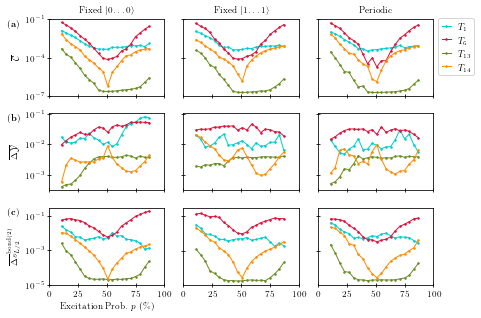

In [37]:
measures = [r"C_1", r"DY_1", r"Dsbisect_2"]
fig, axs = plt.subplots(len(measures), len(BCs), figsize=(2*3.375, 4.5), sharex=True, sharey="row")

t0=250
rmin=1e-1
rmax=50
Npts=50
logbins = np.logspace(np.log10(rmin), np.log10(rmax), Npts+1)

#logbins = np.linspace(rmin, rmax, Npts+1)
for R in [1,6,13,14]:
    Ri = list(Rs).index(R)
    for measi, meas in enumerate(measures):
        for BCi, BC in enumerate(BCs):
            mvals = []
            for ICi, IC in enumerate(ICs):
                Q = Qs[Ri, ICi, BCi]
                if meas == "KL":
                    ess = Q.ebisect(save=True)
                    rs = np.array([])
                    for es in ess[int(t0/Q.dt):]:
                        es = es[es>1e-14]
                        es = np.sort(list(set(es)))
                        rs = np.r_[rs, (es[2:] - es[1:-1]) / ( es[1:-1] - es[:-2])]
                    rs = rs[rs<rmax]
                    rs = rs[rs>rmin]
                    hist, bins = np.histogram(rs, density=True, bins=logbins)
                    x = bins[:-1] + np.diff(bins) / 2
                    mask = (hist*x*rs.size) > 75
                    hist = hist[mask]
                    x = x[mask]
                    qg = (x+x*x) / (1+x+x*x)**(5/2) / (8/27)
                    qp = 1/(1+x)**2
                    Kg = ms.KL_divergence(hist/hist.sum(), qg/qg.sum())
                    Kp = ms.KL_divergence(hist/hist.sum(), qp/qp.sum())
                    mi = np.argmin([Kg, Kp])
                    m = [Kg, Kp][mi]
                    mvals.append(m)
                    print(R, sum(mask), Kg, Kp, mi)
                    log=True
                else:
                    m = Q.get_measure(meas)
                    if len(m.shape) == 2:
                        m = np.mean(m, axis=1)
                        log = False
                    else:
                        log=True
                    mvals.append(np.mean(m[int(t0/Q.dt):]))
            axs[measi, BCi].plot(exprob[1:-3], mvals[1:-3],
                            color=colors[R], 
                            #mec="k", 
                            ls="-", 
                            #mfc="none",
                            marker = "o",
                            ms=1.5,
                            lw=1,
                            label=r"$T_{%s}$"%R)
            axs[measi, BCi].tick_params(axis="both", direction="inout")
          
            axs[-1, BCi].set_xticks([0,25,50,75, 100])
            axs[-1, BCi].set_xticklabels([0,25,50,75, 100])
            axs[measi, BCi].set_xlim(left=0.0)
            axs[measi, 0].set_ylabel(names[meas.split("_")[0]+"avg"])
       
            if log:
                axs[measi, BCi].set_yscale("log")
                
    axs[0,0].set_title(r"Fixed $\vert 0 \dots 0\rangle$")
    axs[0,1].set_title(r"Fixed $\vert 1 \dots 1\rangle$")
    axs[0,2].set_title("Periodic")  
    axs[-1, 0].set_xlabel(r"Excitation Prob. $p~(\%)$")

yticks_list = [[1e-1, 1e-4, 1e-7],
              [1e-1, 1e-2, 1e-3],
              [1e-1, 1e-3, 1e-5]]
#              [1e-1,1e-2,1e-3]]
for i, yticks in enumerate(yticks_list):
    axs[i,0].set_yticks(yticks)
    axs[i,0].tick_params(axis="both", direction="inout")
    axs[i,0].minorticks_off()
    axs[i, 0].text(-0.36, 0.9, letters[i], transform=axs[i,0].transAxes)
    
axs[0,len(BCs)-1].legend(ncol=1, bbox_to_anchor=(1, 1.065), loc="upper left", handlelength=1)
plt.tight_layout()
plt.savefig("figures/IC-BC_scan_L15-N500.pdf")


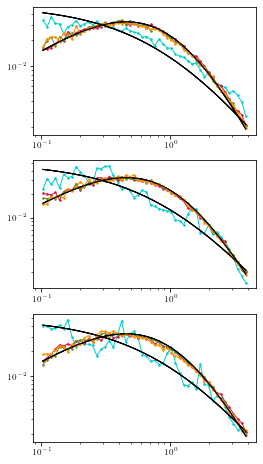

In [110]:

t0=250
rmin=1e-1
rmax=4
Npts=50
logbins = np.logspace(np.log10(rmin), np.log10(rmax), Npts+1)

linbins = np.linspace(0, rmax, Npts+1)

inbins = logbins

fig, axs = plt.subplots(3,1, figsize=(4,8))
for r, R in enumerate([1,6,13,14]):
    Ri = list(Rs).index(R)
    #ax = axs[r//2, r%2]
    for c, IC in enumerate(["r11", "r51", "r83"]):
        ICi = list(ICs).index(IC)
        ax = axs[c]
        Q = Qs[Ri, ICi, 0]
        ess = Q.ebisect(save=True)
        rs = np.array([])
        for es in ess[int(t0/Q.dt):]:
            es = es[es>1e-14]
            es = np.sort(list(set(es)))
            rs = np.r_[rs, (es[2:] - es[1:-1]) / ( es[1:-1] - es[:-2])]
        rs = rs[rs<rmax]
        rs = rs[rs>rmin]
        hist, bins = np.histogram(rs, density=True, bins=inbins)
        x = bins[:-1] + np.diff(bins) / 2
        mask = (hist*x*rs.size) > 75
        hist = hist[mask]
        x = x[mask]
        qg = (x+x*x) / (1+x+x*x)**(5/2) / (8/27)
        qp = 1/(1+x)**2
        Kg = ms.KL_divergence(hist/hist.sum(), qg/qg.sum())
        Kp = ms.KL_divergence(hist/hist.sum(), qp/qp.sum())
        ax.plot(x, hist/hist.sum(), color=colors[R], marker="o", ms=1.5, lw=1)
        ax.plot(x, qg/qg.sum(), c="k", lw=1)
        ax.plot(x, qp/qp.sum(), c="k", lw=1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        

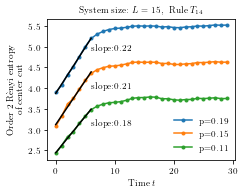

In [99]:
fig,ax = plt.subplots(1,1, figsize=(3.375,2.6))
t0=7
for j in [3,2,1]:
    Q = Qs[3,j,-1]
    y = Q.get_measure("sbisect_2")
    x = Q.ts
    m, b = np.polyfit(x[0:t0], y[0:t0], 1)
    ax.plot(x[:30], y[:30], 
            marker="o", 
            label=f"p={exprob[j]/100}",
           ms=3)
    ax.plot(x[:t0], m*x[:t0]+b, c="k")
    ax.text(6, (j-1)*0.9 + 3.1, f"slope:{round(m,2)}")
ax.set_title("System size: $L=%s$,~~Rule $T_{14}$"%Q.L)
ax.set_xlabel("Time $t$")
ax.set_ylabel(r"Order 2 R\`enyi entropy"+"\n of center cut")
plt.legend(frameon=False)
plt.savefig("figures/rule-14_balistic-entropy_translation-invariant-IC.pdf", bbox_inches="tight")

## Phase gate angle sweep

In [4]:
der = r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data"
# Parameters template
params_template = dict(
              T=1000.0,
              dt=1.0,
              R=6,
              r=1,
              BC="1-00",
              IC="c3_f1",
              E=0.0,
              N=1,
              totalistic=False,
              trotter=True)


phis = np.arange(0, 180+6, 6)
Ls=[6, 7, 8, 9, 10, 11, 12, 13,14,15, 16, 17, 18, 19]
Rs = [1,6,13,14]
Qs = np.zeros((len(Ls), len(Rs), len(phis)), dtype="object")
for Li, L in enumerate(Ls):
    for Ri, R in enumerate(Rs):
        for phi, ph in enumerate(phis):
            params = copy(params_template) 
            params["V"] = f"HP_{ph}"
            params["hamiltonian"] = False
            params["symmetric"] = False
            params["L"] = L
            params["R"] = R

            QU = QCA(params, der=der)
            QU.MI(1, save=True)

            Qs[Li, Ri, phi] = QU
            QU.close()

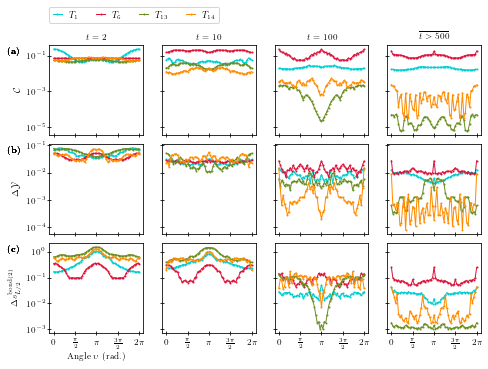

In [9]:

t0 = 500

Cylim = [1e-5, 0.3]
Yylim = [2e-4, 0.1]
Dsbondylim = [1e-3, 2e0]

Cyticks = [1e-5, 1e-3, 1e-1]
Yyticks = [1e-4, 1e-3, 1e-2, 1e-1]
Dsbondticks = [1e-3, 1e-2, 1e-1, 1e0]
    
yticks_list = [Cyticks,
              Yyticks,
              Dsbondticks]
ylims = [Cylim, Yylim, Dsbondylim]


ts = [2,10,100,-1]
measures = ["C_1", "DY_1", "Dsbisect_2"]

fig, axs = plt.subplots(len(measures), len(ts), figsize=(2*3.367, 5.0),
                        sharex="col", sharey="row")
for Ri, R in enumerate(Rs):
    for ti, t in enumerate(ts):
        vals_list = []
        for measi, meas in enumerate(measures):
            vals = []
            for phi, ph in enumerate(phis):
                Q = Qs[-1, Ri, phi]
                m = Q.get_measure(meas)
                if t != -1:
                    vals.append(m[t])
                else:
                    vals.append(np.mean(m[t0:]))
            vals_list.append(vals)
        
        for measi, (vals, meas) in enumerate(zip(vals_list, measures)):
            axs[measi, ti].set_yscale("log")
            axs[measi, ti].plot(
                np.arange(0,360+6,6)*np.pi/180, 
                vals+vals[-2::-1], 
                c=colors[R], 
                ms=2,
                lw=1,
                marker=".", 
                label=names[R], 
                mfc=colors[R],
                #ls="none"
            )
            axs[measi, ti].tick_params(axis="both", direction="inout")
            axs[measi, 0].set_ylabel(names[meas.split("_")[0]])
            #axs[measi, ti].set_ylim(ylims[measi])
            axs[measi, ti].minorticks_off()
        axs[-1, ti].set_xticks([0,np.pi/2, np.pi, 3 *np.pi/2, 2*np.pi])
        axs[-1, ti].set_xticklabels([r"$0$",r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
        if t == -1:
            axs[0, ti].set_title(r"$\overline{t>%s}$"%t0)
        else:
            axs[0, ti].set_title(r"$t={%s}$"%t)
    axs[-1,0].set_xlabel(r"Angle $\upsilon$ (rad.)")
    
    for measi, meas in enumerate(measures):
        axs[measi, 0].set_yticks(yticks_list[measi]) 
        axs[measi, 0].text(-0.45, 0.9, letters[measi], transform=axs[measi, 0].transAxes)
    
axs[0,0].legend(ncol=len(Rs), frameon=True, handlelength=1, 
                bbox_to_anchor=[-0.05, 1.2], loc="lower left",
                bbox_transform=axs[0,0].transAxes)
plt.subplots_adjust(left=0.09,  top=0.89,    hspace=0.1, 
                   right=0.98, bottom=0.09, wspace=0.2)
plt.savefig("figures/phase_gate_scan.pdf")

<AxesSubplot:xlabel='Site $j$', ylabel='Time $t$'>

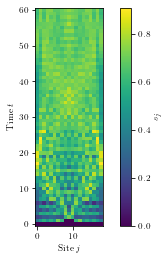

In [187]:
Qs[-1,0,10].plot("s_1", tmax=60)

## Simple line cuts

In [3]:
der = r"/home/lhillber/documents/research/cellular_automata/qeca/qca/data"
params_template = dict(
              L=19,
              T=1000.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c3_f1",
              E=0.0,
              N=1,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

Hparams_template = dict(
              L=19,
              T=1000.0,
              dt=0.1,
              R=4,
              r=2,
              V="X",
              BC="1-0000",
              IC="c3_f0-2",
              E=0.0,
              N=1,
              totalistic=True,
              hamiltonian=True,
              trotter=True,
              symmetric=True)

Ls = list(np.arange(6, 20))
Rs = [6, 1, 14, 4, 26]
ICs = [("c3_f1", "c3_f0-2"), "R123"]
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
     
for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            if R in (4, 26):
                params = copy(Hparams_template)
                ICj = 1
                
            else:
                params = copy(params_template)
                ICj = 0
            if ICi == 0:
                IC = ICs[ICi][ICj]
            params["R"] = R
            params["L"] = L
            params["IC"] = IC
            Q = QCA(params, der=der)
            assert np.any([k in Q.available_tasks for k in 
                      ("bisect", "bipart",  "ebisectdata", "ebipartdata")])
            Qs[ICi, Ri, Li] = Q

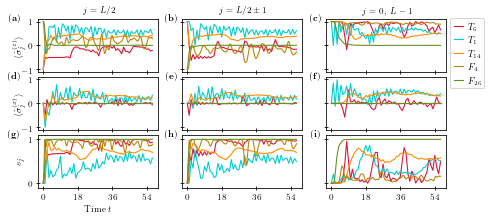

In [62]:
from figures import lettering
measures = ["exp_Z", "exp_X", "s_2"]

fig, axs = plt.subplots(int(len(measures)), 3, figsize=(2*3.375, 3))
for Ri, R in enumerate(Rs):
    Q = Qs[0, Ri, -1]
    t0 = 3*Q.L
    timeticks = [i*(Q.L-1) for i in range(4)]
    count = 0
    for measi, meas in enumerate(measures):
        mask = Q.ts<=t0
        ts = Q.ts[mask]
        for ji, (j, title) in enumerate(zip((int(L/2), int(L/2)-1, 0), ("$j=L/2$","$j=L/2 \pm 1$", "$j=0,~L-1$"))):
            m = Q.get_measure(meas)[mask][:, j]
            if R in [4, 26]:
                marker="."
                ms = 1
            else:
                marker="o"
                ms=1.4
            if meas.split("_")[0] == "exp":
                name = r"$\langle \hat{\sigma}^{(%s)}_{j}\rangle$"%meas.split("_")[1].lower()
                ylim = [-1.1, 1.1]
                lp = -4
            else:
                name = names[meas]
                ylim=None
            if meas == "s_2":
                name = r"$s_{j}$"
                ylim = [-0.1, 1.1]
                lp = None
            axs[measi, ji].set_ylim(ylim)
            axs[measi, ji].plot(ts, m, marker=None, ms=ms, lw=1.1, color=colors[R], label=names[R])
            axs[measi, ji].tick_params(axis="both", direction="inout")
            axs[measi, ji].set_xticks(timeticks)
            if ji == 0 :
                axs[measi, ji].set_ylabel(name, labelpad=lp)
                xlett = -0.2
            else:
                axs[measi, ji].set_yticklabels([])
                xlett = -0.09
            if Ri == 0:
                lettering(axs[measi, ji], xlett, 1, count)
                count += 1
            if measi == 0:
                axs[measi, ji].set_title(title)
            #axs[measi, ji].set_xticklabels([])
    axs[-1, 0].set_xticklabels(timeticks)
    axs[-1, 0].set_xlabel(names["time"])
    axs[0, -1].legend(loc="upper left", bbox_to_anchor=(1.0, 1.1),
                  handlelength=1, handletextpad=0.5, bbox_transform=axs[0,-1].transAxes)
plt.subplots_adjust(left=0.07, right=0.91, bottom=0.15, top=0.93, wspace=0.2, hspace=0.1)
plt.savefig("figures/simple_linecuts.pdf")

In [64]:
3*19

57